In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchtrainer import img_util
from torchtrainer import transforms
import imgaug.augmenters as iaa
import re
from torch.utils.data import dataloader as torch_dataloader
from functools import partial
import torch
from torchtrainer.imagedataset import (ImageDataset, ImageSegmentationDataset, 
                                       ImagePatchDataset, ImagePatchSegmentationDataset)

In [9]:
# Create dataloaders
def name_to_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = int(m.group(1))
    if index<30:
        return 0
    else:
        return 1
    
def name_to_label_path_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename

def filename_filter(img_filename, test=False):
    '''Filter DRIVE images for getting only training or test images.
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
    test : bool
        If True, the function checks if the image should be in the test set
    
    Returns
    -------
    bool
        If `test` is False, returns True if the image should be in the training set and
        False if it should be in the test set. Return values are reversed if `test` is True
    '''
    
    if test:
        return 'test' in img_filename
    else:
        return 'test' not in img_filename

root_dir = Path('../../../research/drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'
mask_dir = root_dir/'mask'

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=None)
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

# Image transformations
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 500, "width": 500}),
                            ])
transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 200, "width": 200}),
                            ])
transform_funcs2 = [transforms.TransfToImgaug(), transforms.translate_imagaug_seq(imgaug_seq), 
                    transforms.TransfToTensor()]

In [21]:
# Create ImageDataset instance
#dataset = ImageDataset(img_dir, name_to_label_map=name_to_label_map, filename_filter=filename_filter, 
#                       img_opener=img_opener_partial, transforms=transform_funcs, cache_size = 3*584*565*3)
#dataset = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_to_label_path_map, 
#                                   filename_filter=filename_filter, img_opener=img_opener_partial, 
#                                   label_opener=label_opener_partial, transforms=transform_funcs, cache_size = 3*584*565*3)
#dataset = ImagePatchDataset((100, 100), img_dir, name_to_label_map=name_to_label_map, filename_filter=filename_filter, 
#                            img_opener=img_opener_partial, transforms=transform_funcs, 
#                            patch_transforms=transform_funcs2, cache_size = 40*584*565*3)
dataset = ImagePatchSegmentationDataset((100, 100), img_dir, label_dir, stride=(50, 50), name_to_label_map=name_to_label_path_map, 
                                   filename_filter=filename_filter, img_opener=img_opener_partial, 
                                   label_opener=label_opener_partial, transforms=transform_funcs, patch_transforms=transform_funcs2, cache_size = 40*584*565*3)

print(dataset[0])
#dataset.check_dataset()
#imgs, labels = dataset.as_tensor()
#train_ds, valid_ds = dataset.split_train_val(0.2)

# We can grab all images as tensor
#x_train,y_train = train_ds.as_tensor()
#x_valid,y_valid = valid_ds.as_tensor()

# Or create a dataloader
#train_dl = torch_dataloader.DataLoader(train_ds, batch_size=4, shuffle=True)
#valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=4, shuffle=False)

torch.Size([200, 200])
[tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  9,   9,   9,  ..., 218, 219, 220],
         [ 10,  10,  10,  ..., 220, 220, 220],
         [ 10,  10,  10,  ..., 221, 220, 220]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  8,   8,   8,  ..., 133, 134, 134],
         [  9,   9,   9,  ..., 134, 134, 134],
         [  9,   9,  10,  ..., 135, 134, 134]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  6,   6,   6,  ...,  79,  79,  80],
         [  7,   7,   7,  ...,  82,  81,  81],
         [  7,   7,   8,  ...,  83,  83,  82]]], dtype=torch.uint8), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0

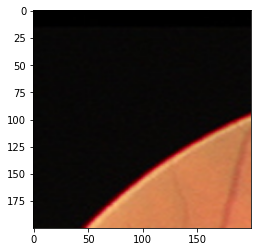

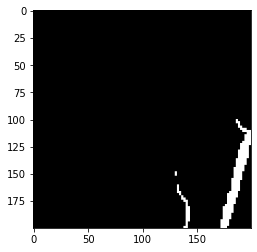

In [11]:
plt.imshow(dataset[1][0].permute(1, 2, 0))
plt.figure()
plt.imshow(dataset[1][1], 'gray')

In [21]:
cm = dataset.cache_manager
print(cm.cache_size)
print(cm.data.keys())

26396800
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


In [19]:
dataset[0][1].shape

torch.Size([200])

In [29]:
class A(object):
    def __init__(self):
        print('Running A.__init__')
        super(A,self).__init__()
class B(A):
    def __init__(self):
        print('Running B.__init__')        
        # super(B,self).__init__()
        A.__init__(self) 

class C(A):
    def __init__(self):
        print('Running C.__init__')
        super(C,self).__init__()
class D(B,C):
    def __init__(self):
        print('Running D.__init__')
        super(D,self).__init__()

foo=D()

Running D.__init__
Running B.__init__
Running A.__init__
None


In [6]:
ImagePatchSegmentationDataset.mro()

[torchtrainer.imagedataset.ImagePatchSegmentationDataset,
 torchtrainer.imagedataset.ImageSegmentationDataset,
 torchtrainer.imagedataset.ImageDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object]

In [1]:
def img_opener(img_file_path, is_label=False):
    
    if is_label: 
        img = torch.randint(0, 2, (50, 500, 500)) #np.random.randint(0, 2, (50, 500, 500))
    else:
        img = torch.randint(0, 256, (50, 500, 500)) #np.random.randint(0, 256, (50, 500, 500))
        
    return img

patch_size = (50, 100, 100)
stride = (50, 50, 50)


imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 500, "width": 500}),
                            ])
img_transform_funcs = [] #transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)

# Patch transformations
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 120, "width": 120}),
                            ])
patch_transform_funcs = [partial(transforms.transf_to_tensor, is_3d=False), transforms.transf_normalize] 
                           #[transforms.transf_to_imgaug, transforms.translate_imagaug_seq(imgaug_seq), 
                           #transforms.transf_to_tensor]

# Create ImageDataset instance
dataset = ImagePatchDataset(patch_size, img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=filename_filter,
                            img_opener=img_opener, label_opener=partial(img_opener, True), 
                            transforms=img_transform_funcs, patch_transforms=patch_transform_funcs, stride=stride)

#dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(0.2)

# We can grab all images as tensor
x_train,y_train = train_ds.as_tensor()
x_valid,y_valid = valid_ds.as_tensor()

# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=4, shuffle=False)

NameError: name 'iaa' is not defined